# Линейная регрессия
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW03] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

##### Соколов Ярослав

In [1]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from typing import Optional
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

In [2]:
def read_data(path="boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    np.random.seed(42)
    np.random.shuffle(dataframe)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [3]:
def generate_synthetic(size:int, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Также чтобы оценить качество модели нам понадобится метрика $R^2$. Реализуйте обе эти метрики.

In [4]:
def mse(y_true: np.ndarray, y_pred: np.ndarray):
    return np.mean(np.square(y_true - y_pred))

def r2(y_true: np.ndarray, y_pred: np.ndarray):
    y_mean = np.mean(y_true)
    v = np.sum(np.square(y_mean - y_true))
    u = np.sum(np.square(y_true - y_pred))
    return 1 - u / v

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [5]:
class NormalLR:
    def __init__(self):
        self._w = None
        self._x_scaler = None
        self._y_scaler = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        self._fit_scaler(X, y)
        X, y = self._transform(X, y)
        self._w = np.linalg.pinv(X) @ y
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        X, _ = self._transform(X=X, y=None)
        y = X @ self._w
        _, y = self._inverse_transform(X=None, y=y)
        return y

    def _fit_scaler(self, X: np.ndarray, y: np.ndarray):
        self._x_scaler = StandardScaler().fit(X)
        self._y_scaler = StandardScaler().fit(y.reshape(-1, 1))

    def _transform(self, X: Optional[np.ndarray], y: Optional[np.ndarray]) -> tuple:
        x_ret = NormalLR._add_bias(self._x_scaler.transform(X)) if X is not None else None
        y_ret = self._y_scaler.transform(y.reshape(-1, 1)).reshape(-1) \
            if y is not None else None
        return x_ret, y_ret

    def _inverse_transform(self, X: Optional[np.ndarray], y: Optional[np.ndarray]) -> tuple:
        x_ret = self._x_scaler.inverse_transform(X) if X is not None else None
        y_ret = self._y_scaler.inverse_transform(y.reshape(-1, 1)).reshape(-1) \
            if y is not None else None
        return x_ret, y_ret

    @staticmethod
    def _add_bias(X: np.ndarray) -> np.ndarray:
        return np.hstack((X, np.ones((X.shape[0], 1), dtype=X.dtype)))

In [6]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [7]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.009185933298555021, R2: 0.9987384962681313


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций. В задании необходимо использовать регуляризацию Лассо с коэффициентом `l`.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

In [8]:
class GradientLR:
    def __init__(self, alpha:float, iterations=10000, l=0.):
        self._lr = alpha
        self._iterations = iterations
        self._reg = l

        self._w = None

        self._x_scaler = None
        self._y_scaler = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        self._fit_scaler(X, y)
        X, y = self._transform(X, y)

        self._w = np.zeros(X.shape[1], dtype=np.float32)

        for _ in range(self._iterations):
            self._w -= self._lr * self._grad(X, y, self._w, self._reg)

    def predict(self, X: np.ndarray) -> np.ndarray:
        X, _ = self._transform(X=X, y=None)
        y = X @ self._w
        _, y = self._inverse_transform(X=None, y=y)
        return y

    def _fit_scaler(self, X: np.ndarray, y: np.ndarray):
        self._x_scaler = StandardScaler().fit(X)
        self._y_scaler = StandardScaler().fit(y.reshape(-1, 1))

    def _transform(self, X: Optional[np.ndarray], y: Optional[np.ndarray]) -> tuple:
        x_ret = NormalLR._add_bias(self._x_scaler.transform(X)) if X is not None else None
        y_ret = self._y_scaler.transform(y.reshape(-1, 1)).reshape(-1) \
            if y is not None else None
        return x_ret, y_ret

    def _inverse_transform(self, X: Optional[np.ndarray], y: Optional[np.ndarray]) -> tuple:
        x_ret = self._x_scaler.inverse_transform(X) if X is not None else None
        y_ret = self._y_scaler.inverse_transform(y.reshape(-1, 1)).reshape(-1) \
            if y is not None else None
        return x_ret, y_ret

    @staticmethod
    def _add_bias(X: np.ndarray) -> np.ndarray:
        return np.hstack((X, np.ones((X.shape[0], 1), dtype=X.dtype)))

    @staticmethod
    def _grad(x: np.ndarray, y: np.ndarray, w: np.ndarray, alpha: float) -> np.ndarray:
        main_term = x.T @ (x @ w - y) / x.shape[0]
        reg_term = alpha * np.sign(w)
        return main_term + reg_term

In [9]:
def build_plot(X_train, y_train, X_test, y_test, high: float = 0.02):
    xs = np.linspace(0, high, 100)
    errors = []
    for x in xs:
        regr = GradientLR(0.1, iterations=10000, l=x)
        regr.fit(X_train, y_train)
        errors.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.show()

In [10]:
X, y = generate_synthetic(1024)
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

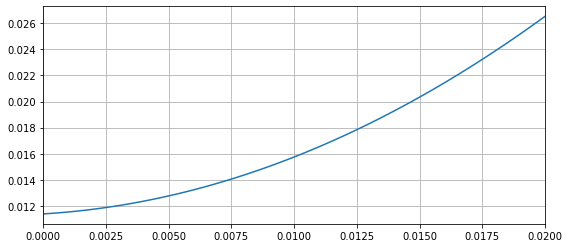

In [11]:
build_plot(X_train, y_train, X_val, y_val)

In [12]:
regr = GradientLR(0.1, iterations=10000, l=0.0014)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.01051813489206365, R2: 0.997309211353074


### Задание 4 (2 балла)
Протесируйте оба метода на данных `boston.csv`, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

In [13]:
X, y = read_data()
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=0.85, shuffle=False)

In [14]:
normal_regr = NormalLR()
normal_regr.fit(X_train_val, y_train_val)
y_pred = normal_regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 22266311.080836896, R2: 0.6872797475661052


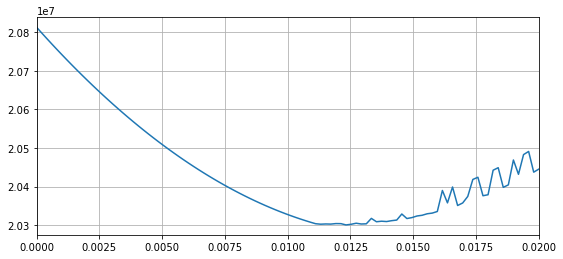

In [15]:
build_plot(X_train, y_train, X_val, y_val)

In [16]:
regr_l1 = GradientLR(0.1, iterations=10000, l=0.0125)
regr_l1.fit(X_train_val, y_train_val)
y_pred = regr_l1.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 21776822.700292584, R2: 0.6941543901313487


### Задание 5 (2 балла)
Проинтерпритируйте полученные результаты. Опишите влияние каждого признака на результат предсказания.

#### Влияние регуляризации на качество
Добавление регуляризации положительно сказалось на качестве на тестовой выборке.
Давайте попробуем посмотреть, может быть какие-то признаки были занулены полностью:

In [17]:
print(regr_l1._w)

[-0.06577434  0.08379927 -0.03043802  0.05937411 -0.15227534  0.30039898
  0.00055898 -0.27504146  0.12418757 -0.10583517 -0.19231798  0.07443939
 -0.41706762 -0.00065789]


Хм, нулевых весов совсем нет, что немного странно на первый взгляд.

На второй взгляд мне кажется, что это недостаток метода градиентного спуска, поскольку
на каждом шаге мы не "оцениваем, выгодно ли нам добавлять признак", как в методе углов,
а просто уменьшаем градиент конкретного веса. Это в итоге приводит к тому, что конкретные веса
не зануляются, а получают на каждом шаге довольно маленький градиент.

#### Влияние признаков
Для начала извлечём сами признаки:

In [18]:
features = np.genfromtxt("boston.csv", delimiter=",", dtype=str)[0]
features

array(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad',
       'tax', 'ptratio', 'b', 'lstat', 'medv'], dtype='<U20')

Давайте посмотрим, какие признаки оказались совсем бесполезными. То есть какие из них
имеют вес меньше определённого трешхолда:



In [19]:
features[np.abs(regr_l1._w) < 1e-3]

array(['age', 'medv'], dtype='<U20')

Далее давайте посмотрим на порядок признаков по их абсолютным весам:


In [20]:
sort_mask = np.argsort(np.abs(regr_l1._w))[::-1]
sorted_features = features[sort_mask]
sorted_ws = regr_l1._w[sort_mask]
np.hstack((sorted_features.reshape(-1, 1), sorted_ws.reshape(-1, 1)))

array([['lstat', '-0.41706762'],
       ['rm', '0.30039898'],
       ['dis', '-0.27504146'],
       ['ptratio', '-0.19231798'],
       ['nox', '-0.15227534'],
       ['rad', '0.12418757'],
       ['tax', '-0.10583517'],
       ['zn', '0.08379927'],
       ['b', '0.07443939'],
       ['crim', '-0.065774344'],
       ['chas', '0.059374113'],
       ['indus', '-0.030438015'],
       ['medv', '-0.00065789477'],
       ['age', '0.0005589799']], dtype='<U32')

Думаю, что из этого массива частично видно влияние каждого признака на результат предсказания.

Но давайте попробуем позанулять веса некоторых признаков.

##### Запомним исходные значения метрик

In [21]:
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 21776822.700292584, R2: 0.6941543901313487


##### Зануляем "бесполезные" medv и age

In [22]:
regr_l1._w[sort_mask[-2:]] = 0
y_pred = regr_l1.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 21781852.654469784, R2: 0.6940837467035121


Качество лишь немного упало
##### Зануляем indus

In [23]:
regr_l1._w[sort_mask[-3:]] = 0
y_pred = regr_l1.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")


MSE: 21408504.885846913, R2: 0.6993272469863164


Качество выросло! Значит этот признак явно был шумным.

##### Занулим chas

In [24]:
regr_l1._w[sort_mask[-4:]] = 0
y_pred = regr_l1.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")


MSE: 22364422.532553677, R2: 0.6859018166714841


Здесь потеря качества уже значительна.
Видимо, этот и все остальные нетронутые признаки являются значительными для модели
и играют важную роль в перфомансе.